In [1]:
!git clone https://github.com/LizaDerb/probing_compositionality

Cloning into 'probing_compositionality'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 600 (delta 112), reused 270 (delta 76), pack-reused 225
Receiving objects: 100% (600/600), 193.67 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Updating files: 100% (111/111), done.


# Датасет

In [2]:
import pandas as pd

In [3]:
eng = pd.read_csv('/content/probing_compositionality/data/eng/TEST-Train.csv')

In [4]:
eng = eng[['mwe', 'label', 'sentence']]

In [5]:
eng.head()

,mwe,label,sentence
0,make_mark,I,For 16 months like a prince in medieval Englan...
1,make_scene,L,But they had made a pleasant enough scene one ...
2,have_word,I,I was in a bad mood and he kept pestering me s...
3,have_word,I,Either I have your word on It or I am afraid y...
4,blow_whistle,L,Needless to say the ref blew the whistle exact...


In [6]:
eng['label'].value_counts()

label
I    2980
L    1720
Name: count, dtype: int64

<Axes: xlabel='mwe'>

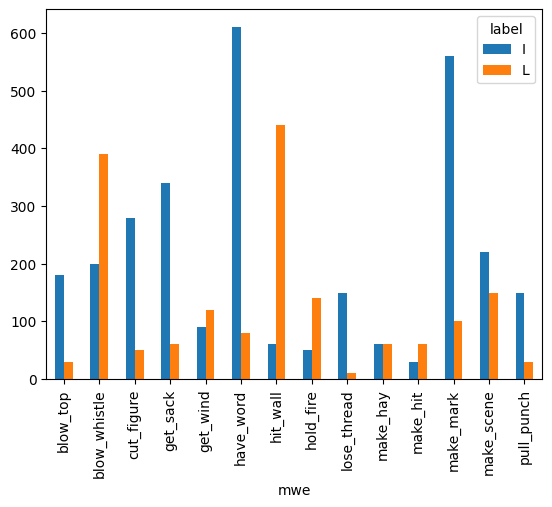

In [7]:
eng.groupby(['mwe', 'label']).size().unstack().plot(kind='bar')

In [8]:
num_idiom_eng = eng['mwe'].value_counts()
num_idiom_eng

mwe
have_word       690
make_mark       660
blow_whistle    590
hit_wall        500
get_sack        400
make_scene      370
cut_figure      330
get_wind        210
blow_top        210
hold_fire       190
pull_punch      180
lose_thread     160
make_hay        120
make_hit         90
Name: count, dtype: int64

In [9]:
inx = eng[eng['label'] == 'I'].index.tolist()[::2]
eng = eng.drop(index=inx)

idiom_train_eng = num_idiom_eng[:7].index.tolist()
idiom_test_eng = num_idiom_eng[7:].index.tolist()

eng_train = eng[eng['mwe'].isin(idiom_train_eng)]
eng_test = eng[eng['mwe'].isin(idiom_test_eng)]

print('train: ', len(eng_train))
print('test: ', len(eng_test))

train:  2393
test:  817


In [10]:
stat_train_eng = eng_train['label'].value_counts().rename('num').to_frame()
stat_train_eng['percentage'] = (stat_train_eng.num * 100 / stat_train_eng.num.sum()).round(1).astype(str) + '%'
stat_train_eng

,num,percentage
label,,
L,1270,53.1%
I,1123,46.9%


In [11]:
stat_test_eng = eng_test['label'].value_counts().rename('num').to_frame()
stat_test_eng['percentage'] = (stat_test_eng.num * 100 / stat_test_eng.num.sum()).round(1).astype(str) + '%'
stat_test_eng

,num,percentage
label,,
L,450,55.1%
I,367,44.9%


# BERT и mBERT

In [ ]:
!pip install datasets

In [13]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

In [14]:
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import warnings
import random
import pickle

import torch
from torch.utils.data import DataLoader

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel

In [15]:
train = Dataset.from_pandas(eng_train)
test = Dataset.from_pandas(eng_test)

In [16]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [17]:
train_labels = le.transform(train['label'])
test_labels = le.transform(test['label'])

In [18]:
train

Dataset({
    features: ['mwe', 'label', 'sentence', '__index_level_0__'],
    num_rows: 2393
})

In [19]:
test

Dataset({
    features: ['mwe', 'label', 'sentence', '__index_level_0__'],
    num_rows: 817
})

In [20]:
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')
bert = AutoModel.from_pretrained('google-bert/bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [21]:
mbert_tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/bert-base-multilingual-cased-sentence')
mbert = AutoModel.from_pretrained('DeepPavlov/bert-base-multilingual-cased-sentence')

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [22]:
torch.cuda.is_available()

True

In [23]:
device_cuda = torch.device("cuda")
device_cpu = torch.device("cpu")

In [24]:
def vectorize_dataset(data, tokenizer, model):
    model = model.to(device_cuda)
    res_cls = []
    res_mean = []
    for batch in tqdm(data):
        toks = tokenizer(batch['sentence'], padding='max_length', truncation=True, return_tensors='pt', max_length=300)
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()})
        res_cls.append(model_output.last_hidden_state[:,0,:]) #достаём вектора для CLS токенов
        res_mean.append(torch.mean(model_output.last_hidden_state, dim=1)) #среднее
    res_cls = torch.vstack(res_cls)
    res_mean = torch.vstack(res_mean)
    return res_cls.detach().cpu().numpy(), res_mean.detach().cpu().numpy()

In [25]:
dl_train = DataLoader(train, batch_size=256, shuffle=False,
                drop_last=False)
dl_test = DataLoader(test, batch_size=256, shuffle=False,
                drop_last=False)
vecs_train_cls, vecs_train_mean = vectorize_dataset(dl_train, bert_tokenizer, bert)
vecs_test_cls, vecs_test_mean = vectorize_dataset(dl_test, bert_tokenizer, bert)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
vecs_train_cls_m, vecs_train_mean_m = vectorize_dataset(dl_train, mbert_tokenizer, mbert)
vecs_test_cls_m, vecs_test_mean_m = vectorize_dataset(dl_test, mbert_tokenizer, mbert)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
vectors = {'vecs_train_cls' : vecs_train_cls, 'vecs_train_mean' : vecs_train_mean,
           'vecs_test_cls' : vecs_test_cls, 'vecs_test_mean' : vecs_test_mean}

for name in vectors.keys():
    with open(f'{name}.pkl', 'wb') as file:
         pickle.dump(vectors[name], file)

In [28]:
vector_names = ['vecs_train_cls', 'vecs_train_mean', 'vecs_test_cls', 'vecs_test_mean']
vecs = []

for name in vector_names:
    with open(f'{name}.pkl', "rb") as fIn:
        vecs.append(pickle.load(fIn))

train_cls = vecs[0]
train_mean = vecs[1]
test_cls = vecs[2]
test_mean = vecs[3]

In [29]:
vectors_m = {'vecs_train_cls' : vecs_train_cls_m, 'vecs_train_mean' : vecs_train_mean_m,
           'vecs_test_cls' : vecs_test_cls_m, 'vecs_test_mean' : vecs_test_mean_m}

for name in vectors_m.keys():
    with open(f'{name}.pkl', 'wb') as file:
         pickle.dump(vectors_m[name], file)

In [31]:
vector_names_m = ['vecs_train_cls', 'vecs_train_mean', 'vecs_test_cls', 'vecs_test_mean']
vecs_m = []

for name in vector_names_m:
    with open(f'{name}.pkl', "rb") as fIn:
        vecs_m.append(pickle.load(fIn))

train_cls_m = vecs_m[0]
train_mean_m = vecs_m[1]
test_cls_m = vecs_m[2]
test_mean_m = vecs_m[3]

In [32]:
def calculate_metrics(true_labels, predictions):
    matrix = confusion_matrix(true_labels, predictions)
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)
    return matrix, acc, prec, rec, f1, roc_auc

In [33]:
def get_results(train_data, train_labels, test_data, test_labels):
    results_train = []
    results_test = []
    for n in tqdm(range(50)):
        clf = MLPClassifier(random_state=n, max_iter=300, verbose=1)
        clf.fit(train_data, train_labels)
        train_pred = clf.predict(train_data)
        test_pred = clf.predict(test_data)
        results_train.append(calculate_metrics(train_labels, train_pred))
        results_test.append(calculate_metrics(test_labels, test_pred))
    return results_train, results_test, test_pred

In [34]:
labels = [0, 1]

In [ ]:
results_train_mean, results_test_mean, test_pred_mean = get_results(train_mean, train_labels, test_mean, test_labels)
res_test_mean = pd.DataFrame(results_test_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_mean = pd.DataFrame(results_train_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_mean.to_csv('res_test_mean.csv')
res_train_mean.to_csv('res_train_mean.csv')

In [36]:
print(classification_report(test_labels, test_pred_mean, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.69      0.74      0.71       367
           L       0.77      0.74      0.75       450

    accuracy                           0.74       817
   macro avg       0.73      0.74      0.73       817
weighted avg       0.74      0.74      0.74       817



In [ ]:
results_train_mean_m, results_test_mean_m, test_pred_mean_m = get_results(train_mean_m, train_labels, test_mean_m, test_labels)
res_test_mean_m = pd.DataFrame(results_test_mean_m, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_mean_m = pd.DataFrame(results_train_mean_m, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_mean_m.to_csv('res_test_mean_m.csv')
res_train_mean_m.to_csv('res_train_mean_m.csv')

In [50]:
print(classification_report(test_labels, test_pred_mean_m, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.68      0.68      0.68       367
           L       0.74      0.74      0.74       450

    accuracy                           0.71       817
   macro avg       0.71      0.71      0.71       817
weighted avg       0.71      0.71      0.71       817



In [ ]:
results_train_cls, results_test_cls, test_pred_cls = get_results(train_cls, train_labels, test_cls, test_labels)
res_test_cls = pd.DataFrame(results_test_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_cls = pd.DataFrame(results_train_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_cls.to_csv('res_test_cls.csv')
res_train_cls.to_csv('res_train_cls.csv')

In [51]:
print(classification_report(test_labels, test_pred_cls, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.65      0.78      0.71       367
           L       0.79      0.66      0.72       450

    accuracy                           0.71       817
   macro avg       0.72      0.72      0.71       817
weighted avg       0.73      0.71      0.71       817



In [ ]:
results_train_cls_m, results_test_cls_m, test_pred_cls_m = get_results(train_cls_m, train_labels, test_cls_m, test_labels)
res_test_cls_m = pd.DataFrame(results_test_cls_m, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_cls_m = pd.DataFrame(results_train_cls_m, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_cls_m.to_csv('res_test_cls_m.csv')
res_train_cls_m.to_csv('res_train_cls_m.csv')

In [52]:
print(classification_report(test_labels, test_pred_cls_m, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.68      0.65      0.67       367
           L       0.73      0.75      0.74       450

    accuracy                           0.71       817
   macro avg       0.70      0.70      0.70       817
weighted avg       0.71      0.71      0.71       817



In [53]:
all_test = [res_test_cls.iloc[:, 2:].mean(), res_test_mean.iloc[:, 2:].mean()]
all_train = [res_train_cls.iloc[:, 2:].mean(), res_train_mean.iloc[:, 2:].mean()]

In [54]:
pd.concat(all_test, axis=1).rename(columns={0:'test_cls', 1:'test_mean'})

,test_cls,test_mean
precision,0.796722,0.775279
recall,0.659467,0.743422
f1,0.721568,0.758978
roc_auc,0.726491,0.739613


In [55]:
pd.concat(all_train, axis=1).rename(columns={0:'train_cls', 1:'train_mean'})

,train_cls,train_mean
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0
roc_auc,1.0,1.0


In [56]:
all_test_m = [res_test_cls_m.iloc[:, 2:].mean(), res_test_mean_m.iloc[:, 2:].mean()]
all_train_m = [res_train_cls_m.iloc[:, 2:].mean(), res_train_mean_m.iloc[:, 2:].mean()]

In [57]:
pd.concat(all_test_m, axis=1).rename(columns={0:'test_cls_m', 1:'test_mean_m'})

,test_cls_m,test_mean_m
precision,0.714171,0.760851
recall,0.723022,0.709378
f1,0.718429,0.734050
roc_auc,0.683909,0.717659


In [58]:
pd.concat(all_train_m, axis=1).rename(columns={0:'train_cls_m', 1:'train_mean_m'})

,train_cls_m,train_mean_m
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0
roc_auc,1.0,1.0


In [59]:
!zip -r /content/file.zip /content/english_vp2

updating: content/english_vp2/ (stored 0%)
updating: content/english_vp2/vecs_test_cls.pkl (deflated 8%)
updating: content/english_vp2/vecs_test_mean.pkl (deflated 8%)
updating: content/english_vp2/vecs_train_cls.pkl (deflated 7%)
updating: content/english_vp2/vecs_train_mean.pkl (deflated 8%)
  adding: content/english_vp2/res_test_mean_m.csv (deflated 63%)
  adding: content/english_vp2/res_train_cls_m.csv (deflated 92%)
  adding: content/english_vp2/res_train_cls.csv (deflated 92%)
  adding: content/english_vp2/res_train_mean.csv (deflated 92%)
  adding: content/english_vp2/res_test_cls_m.csv (deflated 66%)
  adding: content/english_vp2/res_test_cls.csv (deflated 79%)
  adding: content/english_vp2/res_test_mean.csv (deflated 84%)
  adding: content/english_vp2/res_train_mean_m.csv (deflated 92%)
